In [152]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

In [153]:
# Load the data
training_data = pd.read_csv('Data/training.csv')
drop_columns = ['Unnamed: 0', 'pad_id', 'standardized_operator_name', 'average_stage_length', 'average_proppant_per_stage', 'average_frac_fluid_per_stage', 'number_of_stages', 'frac_type']
training_data.drop(columns=drop_columns, inplace=True)
training_data.drop_duplicates(inplace=True)
training_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Convert any "Undefined" or "Unknown" values to NaN
training_data.replace('Undefined', np.nan, inplace=True)
training_data.replace('Unknown', np.nan, inplace=True)

# Before imputing, keep track of rows with missing values for 'OilPeakRate' to remove them later
rows_with_missing_values = training_data[training_data['OilPeakRate'].isnull()].index.to_list()

In [154]:
# Label categorical variables
categorical_columns = ['ffs_frac_type', 'relative_well_position', 'batch_frac_classification', 'well_family_relationship']

# Get numeric columns
numeric_columns = training_data.select_dtypes(include=np.number).columns.to_list()

# Impute categorical variables with the most frequent value
imputer = SimpleImputer(strategy='constant', fill_value='missing')
training_data[categorical_columns] = imputer.fit_transform(training_data[categorical_columns])

# Impute numerical variables with the KNN algorithm
imputer = KNNImputer(n_neighbors=10)
training_data[numeric_columns] = imputer.fit_transform(training_data[numeric_columns])

# Encode categorical variables using OrdinalEncoder
encoder = OrdinalEncoder()
training_data[categorical_columns] = encoder.fit_transform(training_data[categorical_columns])

In [155]:
# Drop rows with missing values for 'OilPeakRate'
training_data.drop(index=rows_with_missing_values, inplace=True)

# Remove outliers in 'OilPeakRate' based on the 1.5*IQR rule
Q1 = training_data['OilPeakRate'].quantile(0.25)
Q3 = training_data['OilPeakRate'].quantile(0.75)
IQR = Q3 - Q1
print('Q1: ', Q1)
print('Q3: ', Q3)
print('IQR: ', IQR)
upper_bound = Q3 + 1.5*IQR
lower_bound = Q1 - 1.5*IQR
training_data = training_data[(training_data['OilPeakRate'] < upper_bound) & (training_data['OilPeakRate'] > lower_bound)]

Q1:  107.91815165000001
Q3:  298.07321790000003
IQR:  190.15506625


In [156]:
# Create a 'well_skew' feature
# The formula for well skew is sqrt(|surface_x - bh_x|^2 + |surface_y - bh_y|^2)
training_data['well_skew'] = np.sqrt((training_data['surface_x'] - training_data['bh_x'])**2 + (training_data['surface_y'] - training_data['bh_y'])**2)

In [157]:
# Create a 'lateral_length' feature
# The formula for lateral length is sqrt(|horizontal_toe_x - bh_x|^2 + |horizontal_toe_y - bh_y|^2)
training_data['lateral_length'] = np.sqrt((training_data['horizontal_toe_x'] - training_data['bh_x'])**2 + (training_data['horizontal_toe_y'] - training_data['bh_y'])**2)

In [158]:
RANDOM_STATE = 19

# Split the data into training and test sets
drop_training_columns = ['OilPeakRate']
X = training_data.drop(columns=drop_training_columns, axis=1)
y = training_data['OilPeakRate']

X_c = X.copy()
y_c = y.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

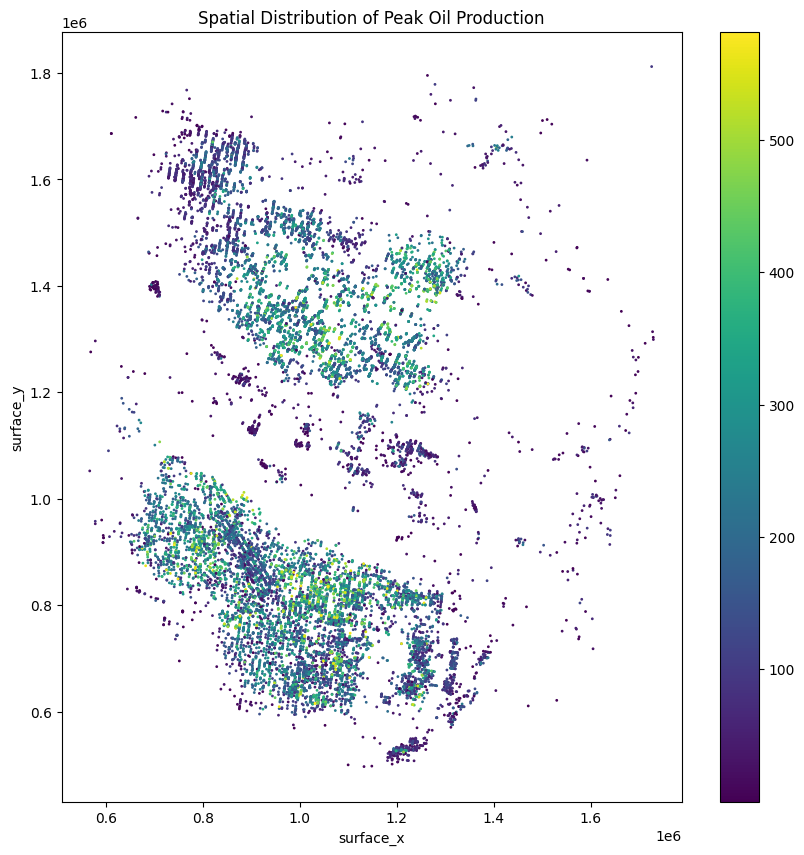

In [159]:
# Plot the well coordinates "surface_x" and "surface_y"
plt.figure(figsize=(10, 10))
plt.scatter(training_data['horizontal_toe_x'], training_data['horizontal_toe_y'], c=training_data['OilPeakRate'], s=1)
plt.colorbar()
plt.xlabel('surface_x')
plt.ylabel('surface_y')
plt.title('Spatial Distribution of Peak Oil Production')
plt.show()

Test set RMSE: 99.93
Training set RMSE: 91.75


/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names



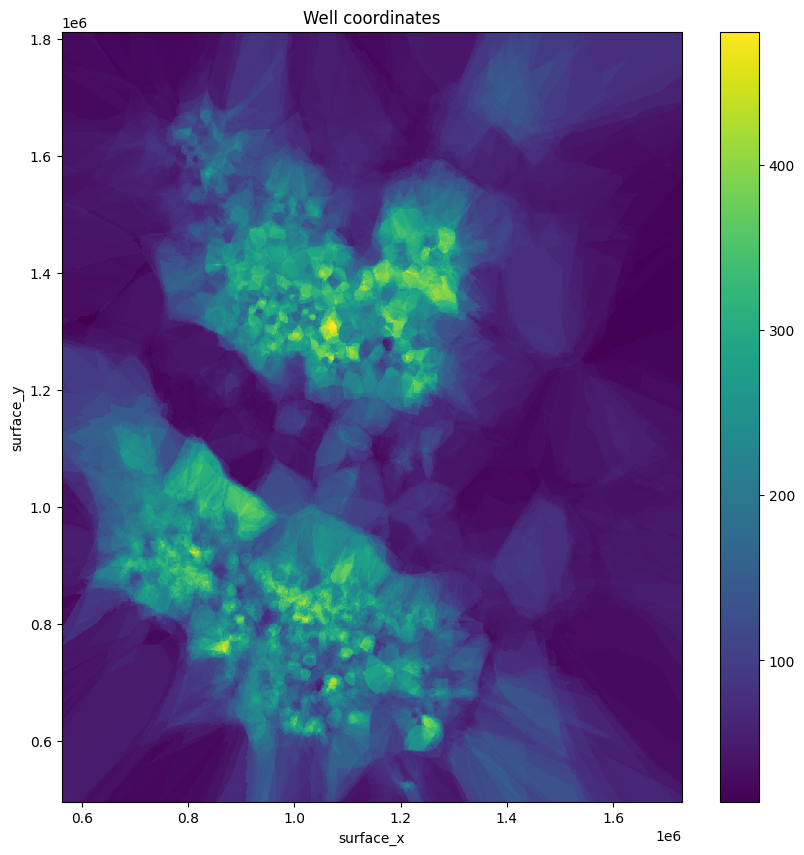

In [160]:
# Instantiate the KNN model for just surface_x and surface_y
X_s = X[['surface_x', 'surface_y']]
y_s = y

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s, test_size=0.2, random_state=RANDOM_STATE)

# Instantiate the KNeighborsRegressor for surface_x and surface_y
model = KNeighborsRegressor(n_neighbors=15)
model.fit(X_train_s, y_train_s)

# Predict the test set labels
y_pred = model.predict(X_test_s)

# Evaluate the test set RMSE
rmse = np.sqrt(mean_squared_error(y_test_s, y_pred))
print('Test set RMSE: {:.2f}'.format(rmse))

# Show the Training set RMSE
y_pred_train = model.predict(X_train_s)
rmse_train = np.sqrt(mean_squared_error(y_train_s, y_pred_train))
print('Training set RMSE: {:.2f}'.format(rmse_train))

# Plot the mesh of the predicted values
# Create a mesh of values to plot
xxl = np.linspace(X_s['surface_x'].min(), X_s['surface_x'].max(), 1000)
yyl = np.linspace(X_s['surface_y'].min(), X_s['surface_y'].max(), 1000)
xx, yy = np.meshgrid(xxl, yyl)
X_grid = np.c_[xx.ravel(), yy.ravel()]

# Predict the values of the mesh
y_pred = model.predict(X_grid)

# Plot the predicted values
plt.figure(figsize=(10, 10))
plt.pcolormesh(xx, yy, y_pred.reshape(xx.shape))
plt.colorbar()
plt.xlabel('surface_x')
plt.ylabel('surface_y')
plt.title('Well coordinates')
plt.show()

# Use the model to create a new column in the training data
training_data['KNN_OilPeakRate'] = model.predict(X_s)

In [161]:
# Make new training and test sets with the new columns
drop_training_columns = ['OilPeakRate']
X = training_data.drop(columns=drop_training_columns, axis=1)
y = training_data['OilPeakRate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# Change the data type of the categorical columns to 'category'
X_train[categorical_columns] = X_train[categorical_columns].astype('category')

In [162]:
# Wrap the HistGradientBoostingRegressor in an AdaBoostRegressor
model = AdaBoostRegressor(estimator=HistGradientBoostingRegressor(max_iter=1000, l2_regularization=0.1),
                          n_estimators=15, random_state=RANDOM_STATE)
model.fit(X_train, y_train)

# Predict the test set labels
y_pred = model.predict(X_test)

# Evaluate the test set RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test set RMSE: {:.2f}'.format(rmse))

# Show the Training set RMSE
y_pred_train = model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print('Training set RMSE: {:.2f}'.format(rmse_train))

Test set RMSE: 78.71
Training set RMSE: 21.46


Test set RMSE: 92.58
Training set RMSE: 83.34


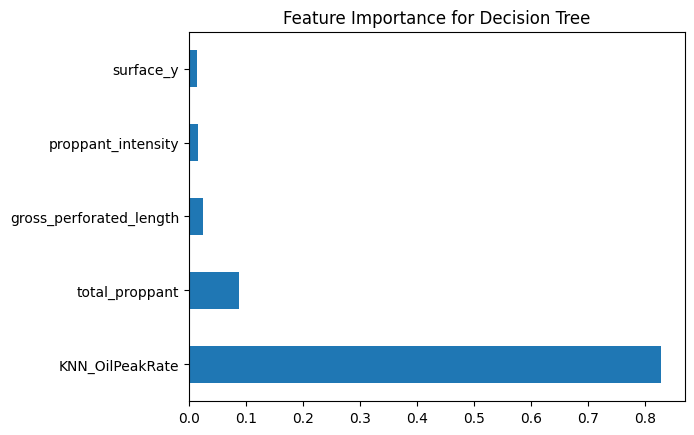

In [163]:
# # Instantiate the DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth=6, random_state=RANDOM_STATE)
model.fit(X_train, y_train)

# Predict the test set labels
y_pred = model.predict(X_test)

# Evaluate the test set RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test set RMSE: {:.2f}'.format(rmse))

# Show the Training set RMSE
y_pred_train = model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print('Training set RMSE: {:.2f}'.format(rmse_train))

# Show feature importances
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feature_importances.nlargest(5).plot(kind='barh')
plt.title("Feature Importance for Decision Tree")
plt.show()

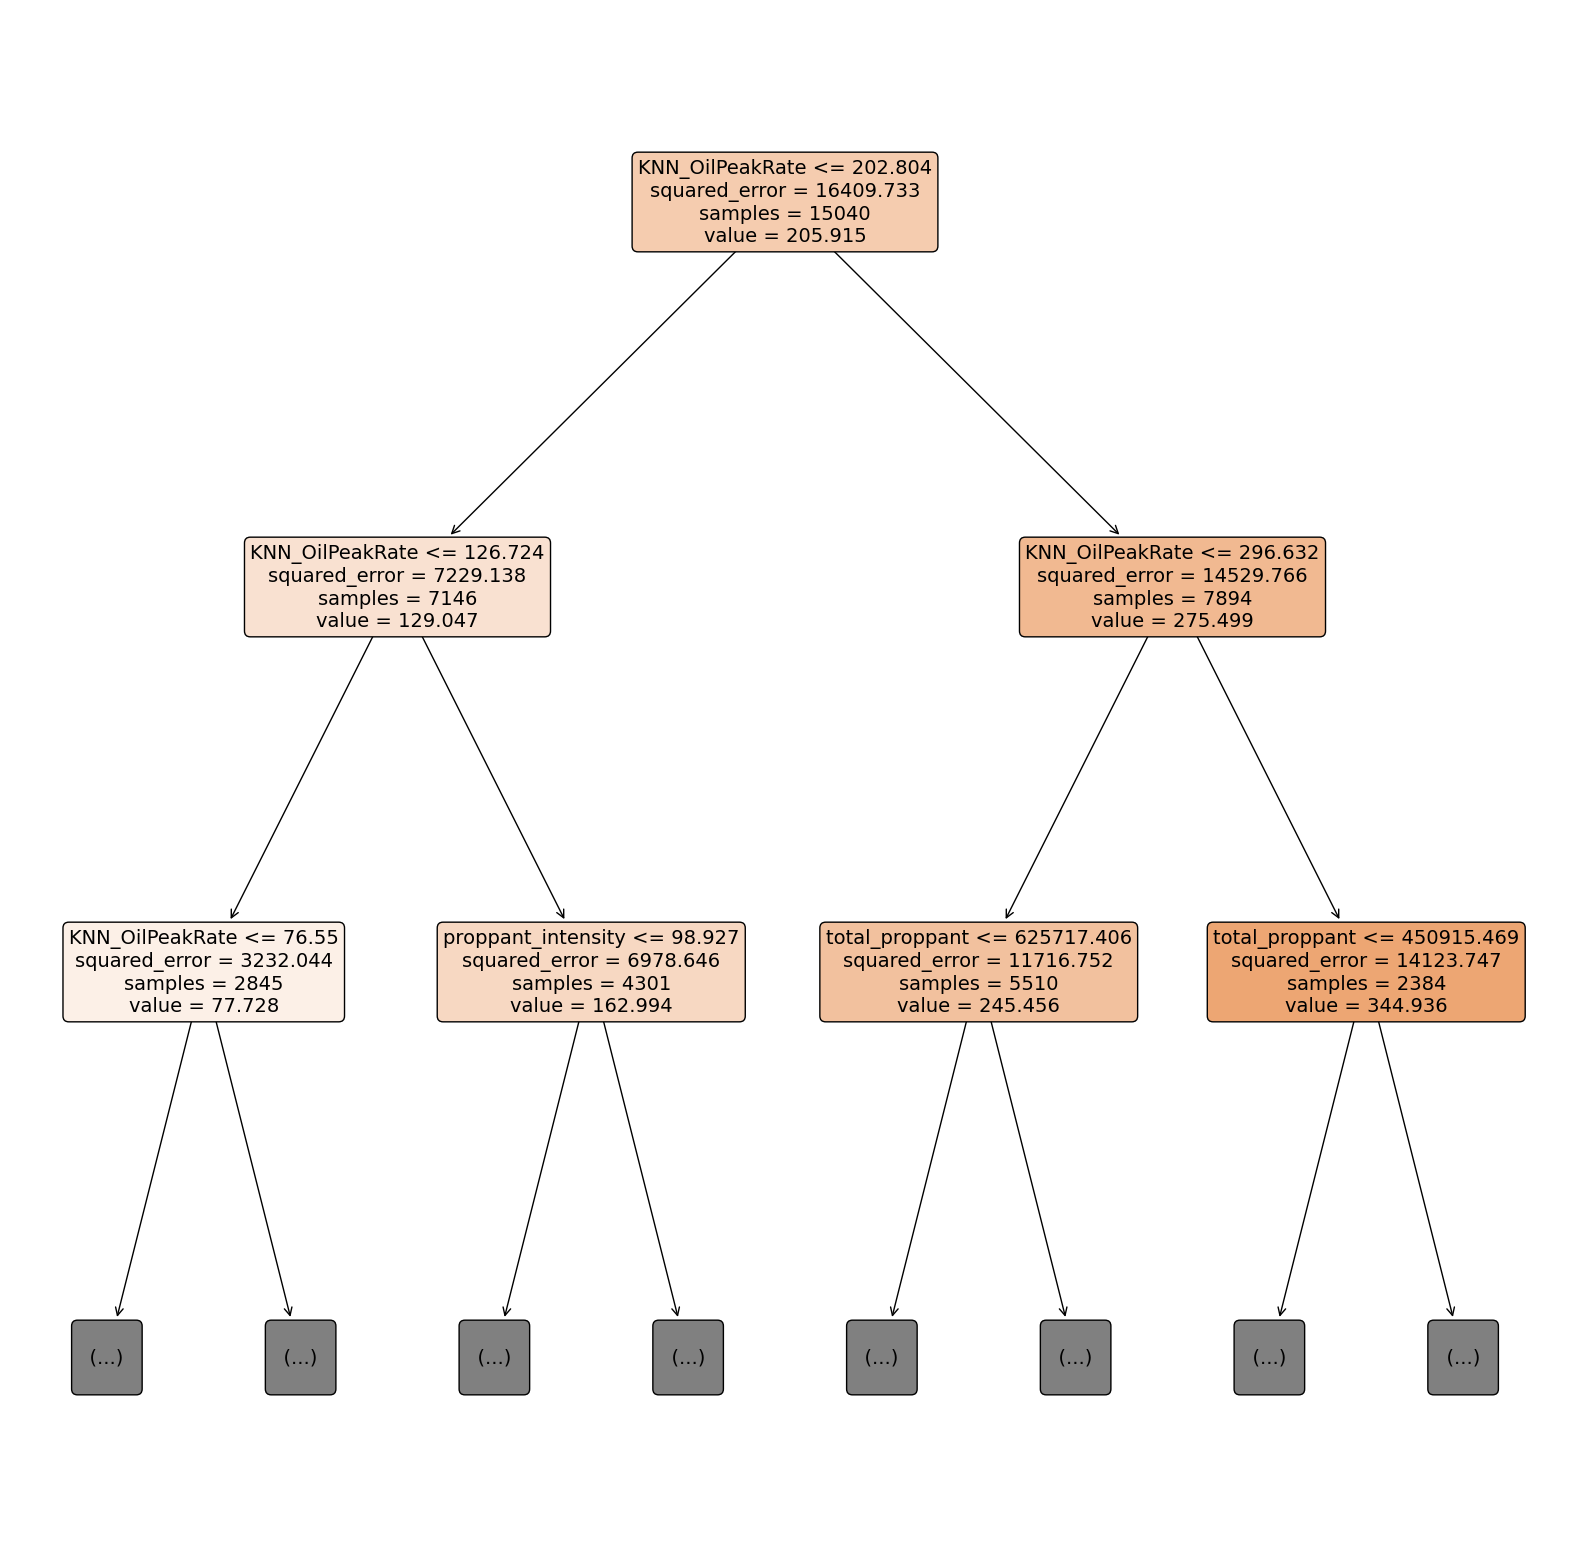

In [164]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 20))
plot_tree(model, filled=True, rounded=True, fontsize=14, feature_names=X_train.columns, max_depth=2)
plt.show()

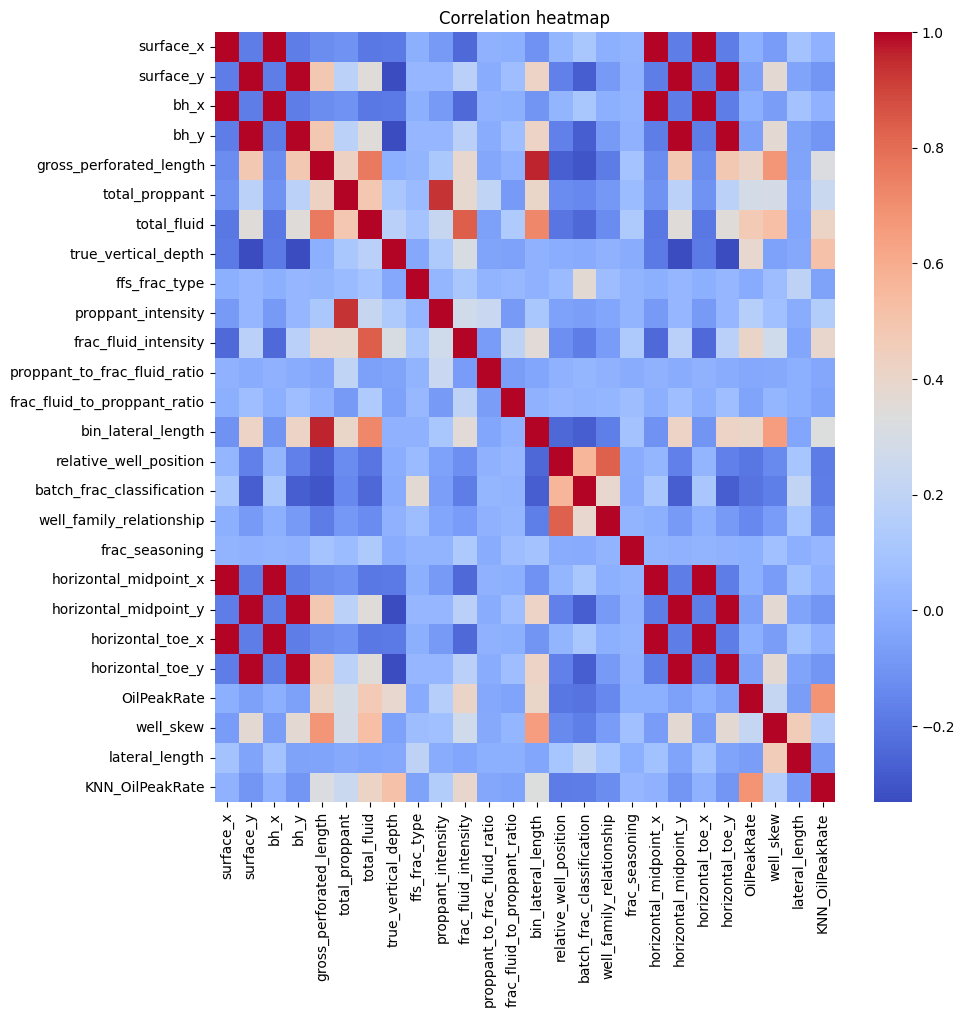

In [165]:
# Plot a correlation heatmap
corr = training_data.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, cmap='coolwarm')
# Title and labels
plt.title('Correlation heatmap')
plt.show()

In [166]:
# Train final KNN model for K = 15
KNN_model = KNeighborsRegressor(n_neighbors=15)

# Fit the model to all the training data
KNN_model.fit(X[['surface_x', 'surface_y']], y)

y_pred = KNN_model.predict(X[['surface_x', 'surface_y']])

X['KNN_OilPeakRate'] = y_pred

# Train final AdaBoost model
final_model = AdaBoostRegressor(estimator=HistGradientBoostingRegressor(max_iter=1000, l2_regularization=0.1),
                          n_estimators=15)

final_model.fit(X, y)

# Save the model to a pickle file
pickle.dump(KNN_model, open('Model/KNN_final.pkl', 'wb'))

# Save the encoder to a pickle file
pickle.dump(encoder, open('Model/encoder.pkl', 'wb'))

# Save the model to a pickle file
pickle.dump(final_model, open('Model/final_model.pkl', 'wb'))

In [167]:
# Make sure the model works by calculating the RMSE on the training data
y_pred = final_model.predict(X)
rmse = np.sqrt(mean_squared_error(y, y_pred))
print('Training set RMSE: {:.2f}'.format(rmse))

Training set RMSE: 24.41


/opt/homebrew/Caskroom/miniconda/base/envs/p311/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but KNeighborsRegressor was fitted with feature names



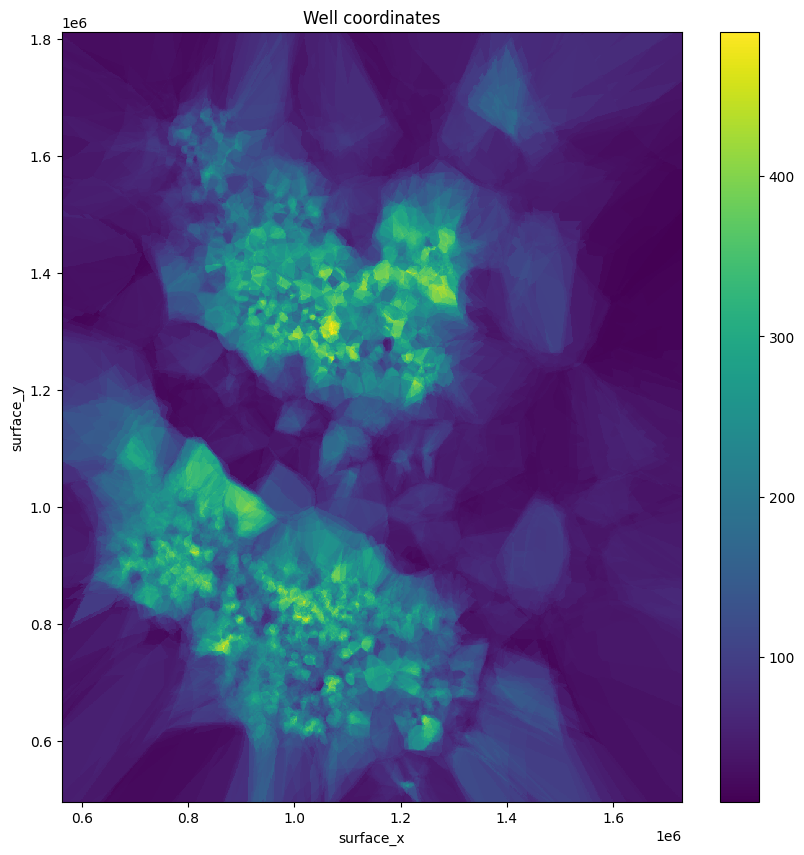

In [168]:
# Plot the mesh of the KNN model
# Create a mesh of values to plot
xxl = np.linspace(X['surface_x'].min(), X['surface_x'].max(), 1000)
yyl = np.linspace(X['surface_y'].min(), X['surface_y'].max(), 1000)
xx, yy = np.meshgrid(xxl, yyl)
X_grid = np.c_[xx.ravel(), yy.ravel()]

# Predict the values of the mesh
y_pred = KNN_model.predict(X_grid)

# Plot the predicted values
plt.figure(figsize=(10, 10))
plt.pcolormesh(xx, yy, y_pred.reshape(xx.shape))
plt.colorbar()
plt.xlabel('surface_x')
plt.ylabel('surface_y')
plt.title('Well coordinates')
plt.show()